In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pylab as plt

sns.set_style('white')

In [2]:
DATA = '../data/'

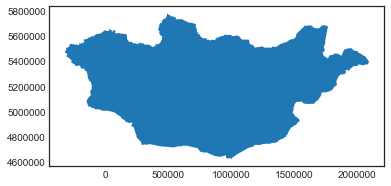

In [3]:
mongolia_map = gpd.read_file(DATA+'GIS/mongolia/mongolia_alagac_utm.shp')
mongolia_map.plot()

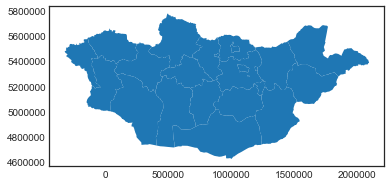

In [4]:
aimag_map = gpd.read_file(DATA+'GIS/aimag_boundaries/aimags_alagac_utm.shp').drop('NAME_L1', axis=1)
aimag_map.plot()

In [5]:
aimag_lookup = {'UB':'Ulaanbaatar',
            'DO':'Dornod',
            'SB':"Su'xbaatar", 
            'KhE':'Xentii',
            'TU':"To'v",
            'GS':"Govisu'mber", 
            'BG':'Dornogovi',
            'DA':'Darxan-Uul',
            'DU':'Dundgovi',
            'OR':'Orxon',
            'UV':"O'vorxangai", 
            'BU':'Bulgan',
            'BKh':'Bayanxongor',
            'AR':'Arxangai',
            'KhU':"Xo'vsgol",
            'ZA':'Zavxan',
            'GA':'Govi-Altai',
            'Bay':"Bayan-O'lgii", 
            'KhO':'Xovd',
            'UG':"O'mnogovi", 
            'UVs':'Uvs',
            'SE':'Selenge'}

In [6]:
aimag_map['Province'] = aimag_map.NAME.replace({aimag_lookup[code]:code for code in aimag_lookup})

Import line list

In [7]:
line_list = pd.read_csv(DATA+'clean/line_list.csv', parse_dates=['date_onset', 'dob', 'date_lab'])

In [8]:
lab_samples = line_list.dropna(subset=['date_lab']).copy()
lab_samples.head()

,id,date_onset,provincecity,dob,age_years,died,confirmed,labconfirmed,date_lab,vaccine_ever,male,month_onset,year_onset
0,389.0,2015-03-30,UB,2014-09-01,0.577686,0.0,1.0,1.0,2015-04-06,0.0,True,3.0,2015.0
1,707.0,2015-04-03,UB,2013-02-02,2.162902,1.0,1.0,1.0,2015-04-04,0.0,True,4.0,2015.0
3,2061.0,2015-04-22,UB,2014-09-23,0.577686,0.0,1.0,1.0,2015-04-24,0.0,True,4.0,2015.0
8,20835.0,2015-11-25,UB,2015-09-01,0.238193,1.0,1.0,1.0,2015-12-01,0.0,True,11.0,2015.0
9,21053.0,2015-12-02,UB,2014-11-19,1.062286,0.0,1.0,1.0,2015-12-14,0.0,False,12.0,2015.0


In [9]:
pd.crosstab(lab_samples.confirmed, lab_samples.labconfirmed)

labconfirmed,0.0,1.0
confirmed,,
0.0,1218,0
1.0,1855,4015


In [10]:
aimag_map.head()

,ID,OBJECTID,AREA_M2,LENGTH_M,TYPE,NAME,PARENT_ID,UNIT_STATU,SHAPE_AREA,SHAPE_LEN,geometry,Province
0,11,2,4.735383e+09,4.786412e+05,2,Ulaanbaatar,1,1,4736.028353,5.405426,(POLYGON ((1064208.858495513 5370725.455944032...,UB
1,21,3,1.235185e+11,2.208690e+06,2,Dornod,1,1,123527.196907,25.333832,"POLYGON ((1540617.076159357 5638446.384644163,...",DO
2,22,4,8.235105e+10,1.323859e+06,2,Su'xbaatar,1,1,82323.874121,14.860285,"POLYGON ((1526003.850553003 5389374.5959672, 1...",SB
3,23,5,8.069372e+10,1.472892e+06,2,Xentii,1,1,80745.839694,16.285330,"POLYGON ((1448514.971882628 5552536.507390657,...",KhE
4,41,6,7.396939e+10,2.046344e+06,2,To'v,1,1,73988.555729,23.471340,"POLYGON ((1193224.564212453 5488464.533822741,...",TU


/Users/fonnescj/anaconda3/envs/dev/lib/python3.6/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


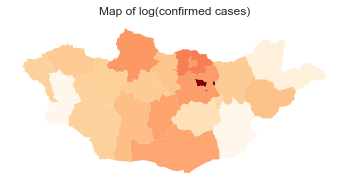

In [11]:
ax = (aimag_map.join(lab_samples.assign(NAME=lab_samples.provincecity.replace(aimag_lookup))
                 .groupby('NAME')
                 .labconfirmed.sum().apply(np.log), on='NAME')
             .plot(column='labconfirmed', cmap='OrRd'))
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)
ax.set_title('Map of log(confirmed cases)');

In [12]:
lab_samples['onset_to_lab'] = (lab_samples.date_lab - lab_samples.date_onset).dt.days

In [13]:
(lab_samples.onset_to_lab<0).sum()

33

In [14]:
lab_samples.loc[lab_samples.onset_to_lab<0, 'onset_to_lab'] = np.nan

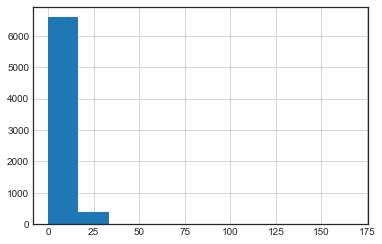

In [15]:
lab_samples.onset_to_lab.hist()

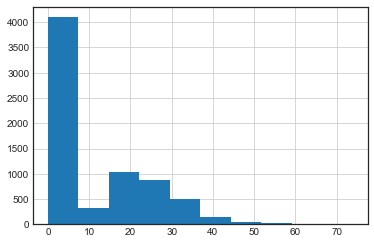

In [16]:
lab_samples.age_years.hist()

Extract clinic-confirmed cases

In [17]:
clinic_confirmed = lab_samples.query('confirmed==1')

In [18]:
clinic_confirmed.isnull().sum()

id                 0
date_onset        29
provincecity       2
dob               22
age_years         24
died               0
confirmed          0
labconfirmed       0
date_lab           0
vaccine_ever    1797
male               0
month_onset       29
year_onset        29
onset_to_lab      56
dtype: int64

### Reporting lag model

In [47]:
from pymc3 import sample, Model, invlogit, Minibatch, fit, generator, sample_ppc
from pymc3 import Deterministic, SVGD, GaussianRandomWalk
from pymc3.gp import cov
from pymc3 import MvNormal, Normal, Bernoulli, Gamma, HalfCauchy, Uniform, Flat
from pymc3 import expand_packed_triangular, LKJCholeskyCov, MvGaussianRandomWalk
from pymc3 import traceplot, forestplot, summary, generator, energyplot
from pymc3.math import invprobit

import theano.tensor as tt
from theano import shared

In [24]:
def interpolate(x0, y0, x):
    
    idx = np.searchsorted(x0, x)
    dl = np.array(x - x0[idx - 1])
    dr = np.array(x0[idx] - x)
    d = dl + dr
    wl = dr / d

    return wl * y0[idx - 1] + (1 - wl) * y0[idx]

In [25]:
lag, confirmed = clinic_confirmed.dropna(subset=['onset_to_lab'])[['onset_to_lab', 'labconfirmed']].values.T

In [28]:
n_knots = 10
knots = np.linspace(lag.min(), lag.max(), n_knots)

with Model() as lag_model:
    
    σ = HalfCauchy('σ', 1)

    y = GaussianRandomWalk('y', shape=n_knots, sd=σ)

    α = interpolate(knots, y, lag)
    
    π = invlogit(α)
        
    confirmation = Bernoulli('confirmation', π, observed=confirmed)

In [30]:
with lag_model:
#     lag_trace = sample(2000, burn=1000, n_init=10000)
    lag_approx = fit(method='fullrank_advi', n=50000)
    lag_trace = lag_approx.sample(1000)

Average Loss = 3,617.3: 100%|██████████| 50000/50000 [00:48<00:00, 1025.98it/s]
Finished [100%]: Average Loss = 3,617.4
INFO (theano.gof.compilelock): Refreshing lock /Users/fonnescj/.theano/compiledir_Darwin-17.5.0-x86_64-i386-64bit-i386-3.6.1-64/lock_dir/lock


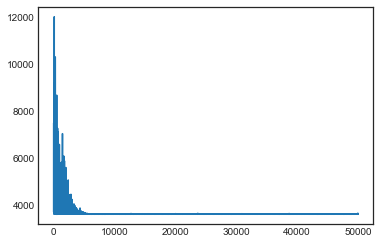

In [31]:
plt.plot(lag_approx.hist)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1254c8550>,
      dtype=object)

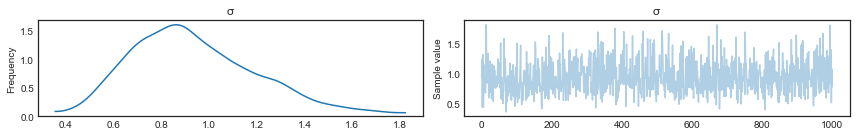

In [32]:
traceplot(lag_trace, varnames=['σ'])

In [33]:
expit = lambda x: 1/(1 + np.exp(-x))

In [34]:
lag_data = pd.DataFrame({'lag': lag,
                        'obs': confirmed})

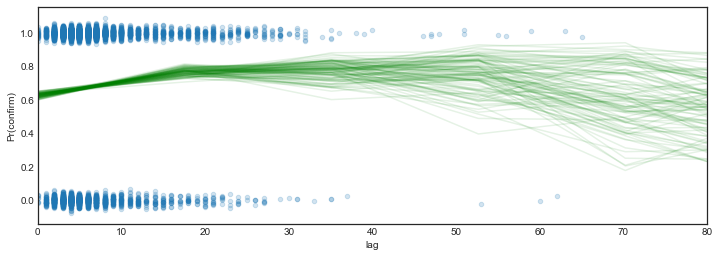

In [35]:
ax = (lag_data.assign(obsj=lag_data.obs+0.02*np.random.randn(len(lag_data)))
              .plot.scatter(x='lag', y='obsj', alpha=0.2, figsize=(12,4)))
plt.plot(knots, expit(lag_trace['y', -100:]).T, 'g-', alpha=0.1)
ax.set_xlim(0,80)
ax.set_ylabel('Pr(confirm)');

### Age model

In [36]:
confirmed, age = clinic_confirmed.dropna(subset=['age_years'])[['labconfirmed', 'age_years']].values.T

In [37]:
n_knots = 20
knots = np.linspace(age.min(), age.max(), n_knots)

with Model() as age_model:
    
    σ = HalfCauchy('σ', 1)

    y = GaussianRandomWalk('y', sd=σ, shape=n_knots)

    α = interpolate(knots, y, age)
    
    π = invlogit(α)
        
    confirmation = Bernoulli('confirmation', π, observed=confirmed)

In [38]:
with age_model:
    age_approx = fit(method='fullrank_advi', n=30000)
    age_trace = age_approx.sample(1000)
    #sample(2000, n_init=50000, tune=1000, njobs=2)

INFO (theano.gof.compilelock): Refreshing lock /Users/fonnescj/.theano/compiledir_Darwin-17.5.0-x86_64-i386-64bit-i386-3.6.1-64/lock_dir/lock
Average Loss = 3,525.2: 100%|██████████| 30000/30000 [00:28<00:00, 1054.43it/s]
Finished [100%]: Average Loss = 3,525.2


Convergence diagnostic

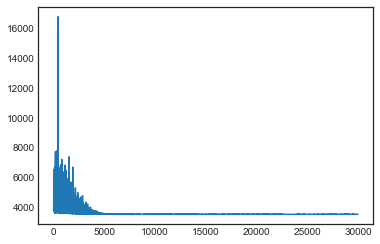

In [39]:
plt.plot(age_approx.hist)

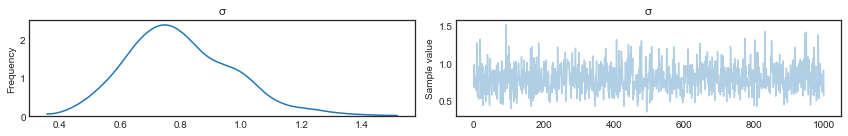

In [41]:
traceplot(age_trace, varnames=['σ']);

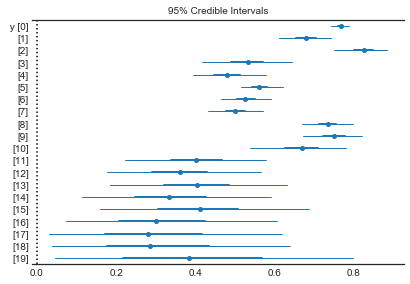

In [42]:
forestplot(age_trace, varnames=['y'], transform=expit)

In [43]:
predictions = pd.DataFrame({'age': age,
                            'obs': confirmed})

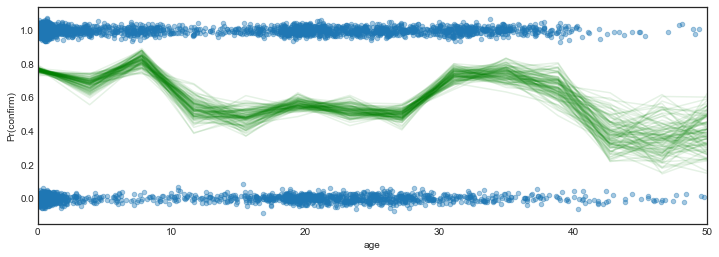

In [44]:
ax = (predictions.assign(obsj=predictions.obs+0.02*np.random.randn(len(predictions)))
              .plot.scatter(x='age', y='obsj', alpha=0.4, figsize=(12,4)))
plt.plot(knots, expit(age_trace['y', -100:]).T, 'g-', alpha=0.1)
ax.set_xlim(0,50)
ax.set_ylabel('Pr(confirm)');

## Combined model

In [46]:
confirmed, age, lag = clinic_confirmed.dropna(subset=['age_years', 'onset_to_lab'])[['labconfirmed', 'age_years', 'onset_to_lab']].values.T

In [52]:
np.array(list(zip(age, lag)))

array([[0.57768649, 7.        ],
       [2.16290212, 1.        ],
       [0.57768649, 2.        ],
       ...,
       [0.64065707, 4.        ],
       [0.48186174, 5.        ],
       [0.44626969, 7.        ]])

In [57]:
n_knots = 20
age_knots = np.linspace(age.min(), age.max(), n_knots)
lag_knots = np.linspace(lag.min(), lag.max(), n_knots)
X, Y = np.meshgrid(age_knots, lag_knots)

In [58]:
from scipy import interpolate

with Model() as combined_model:
    
    packed_L = LKJCholeskyCov('packed_L_α', n=2,   
                                 eta=2., sd_dist=HalfCauchy.dist(3))
    L = expand_packed_triangular(2, packed_L)
    
    Z = MvGaussianRandomWalk('Z', chol=L, shape=(n_knots, 2))
    f = interpolate.interp2d(X, Y, Z)
    α = f(age, lag)
    
    π = invlogit(α)
        
    confirmation = Bernoulli('confirmation', π, observed=confirmed)

ValueError: Invalid length for input z for non rectangular grid

In [ ]:
with combined_model:
    trace_age = fit(method='fullrank_advi', n=50000).sample(1000)
    #sample(2000, n_init=50000, tune=1000, njobs=2)